#Support Vector Regressor para la predicción de la concentración de partículas PM 2.5

In [40]:
#Importación de las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import datetime, timedelta

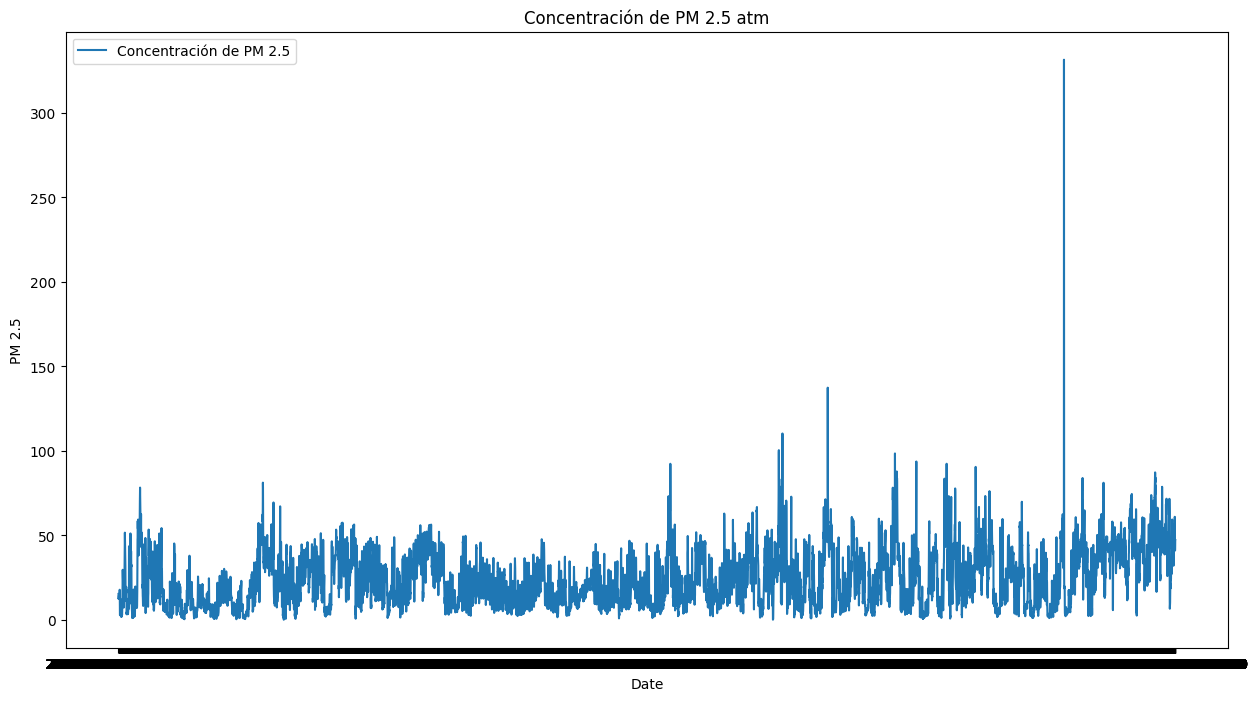

In [4]:
# Se cargan los datos históricos del sensor
df =  pd.read_csv('sensor_33117_ext.csv')
df.dropna(axis=0, inplace=True)
df.rename(columns={'fecha': 'DATE'}, inplace=True)
df.set_index('DATE', inplace=True)

# Creación de una visualización de los datos
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['pm2.5_atm'], label='Concentración de PM 2.5')
plt.xlabel('Date')
plt.ylabel('PM 2.5')
plt.title('Concentración de PM 2.5 atm')
plt.legend()
plt.show()

In [5]:
# Separación de los datos en datos de entrenamiento y datos de prueba
split_date = '2024-04-01 0:00:00'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

###Escalamiento de los datos con la función 'MinMaxScaler' (Sklearn)

*MinMaxScaler* transforma cada característica escalándola a un rango dado (por defecto, entre 0 y 1).
La transformación se realiza individualmente para cada característica en el conjunto de entrenamiento.
La fórmula de transformación es la siguiente: <br>
$X_{std}=\frac{X-X_{min}}{X_{max}-X_{min}}$ <br>
$X_{scaled}=X_{std}\cdot \left ( {max}-{min} \right )+{min}$

Donde:


*   $X_{std}$ es la característica escalada.

*   $X_{max}$ y $X_{min}​$ son los valores mínimo y máximo de la característica en el conjunto de entrenamiento.
*   *min* y *max* son los límites del rango deseado.

Esta transformación es una alternativa al escalamiento de media cero y varianza unitaria.

**Importancia:**
Ayuda a que las características tengan una escala similar, lo que beneficia a muchos algoritmos de aprendizaje automático.
No reduce el efecto de valores atípicos, pero los escala linealmente dentro del rango especificado.
Es especialmente útil para modelos sensibles a la escala de los valores a predecir o los atributos utilizados para ello.

In [6]:
# Escalamiento de los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [7]:
# Se preparan los datos para el entrenamiento del modelo
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 5
X_train, y_train = create_dataset(train_scaled, train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test_scaled, test_scaled, TIME_STEPS)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10303, 5, 1) (10303, 1)
(1449, 5, 1) (1449, 1)


#Parámetros de un Support Vector Regressor


1.   Kernel
  *   Determina la función de transformación utilizada para mapear los datos en un espacio de características (usualmente de mayor dimensión)
  *   Kernel= 'rbf' (Radial Basis Function) Transformación no lineal basada en funciones de base radial (útil para datos no lineales).
2.   Gamma
  *   Controla la forma de la función del kernel: Un valor de gama alto resulta en una función más compleja y flexible, un valor bajo genera una función más suave.
3.  C (box constraint)
  *   Parámetro de regularización: Un valor alto permite que el modelo se sobreajuste a los datos de entrenamiento, un valor bajo impone una mayor regularización, o subajuste
4. Epsilon
  *   Degine la banda de insensibilidad alrededor de la línea de regresión. Únicamente los errores por fuera de esta banda serán penalizados durante el ajuste del modelo



In [9]:
# Establecimiento de los parámetros del SVR
model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)

# Fit del modelo
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10, epsilon=0.05, gamma=0.5)

In [10]:
# Se realizan las predicciones
train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Se transforman los datos a su escala original
train_pred_inv = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Se trunca el modelo a los valores reales que pueden existir
min_value = 0
max_value = 750
train_pred_inv = np.clip(train_pred_inv, min_value, max_value)
test_pred_inv = np.clip(test_pred_inv, min_value, max_value)

In [20]:
# Se evalua el desempeño del modelo
mse_train = mean_squared_error(y_train_inv, train_pred_inv)
mse_test = mean_squared_error(y_test_inv, test_pred_inv)
print("Mean Squared Error on Training Data:", mse_train)
print("Mean Squared Error on Testing Data:", mse_test)
print('r squared coefficient on Testing Data: ', round(r2_score(y_test_inv, test_pred_inv), 2))

Mean Squared Error on Training Data: 27.515036515720826
Mean Squared Error on Testing Data: 87.08827300271903
r squared coefficient on Testing Data:  0.77


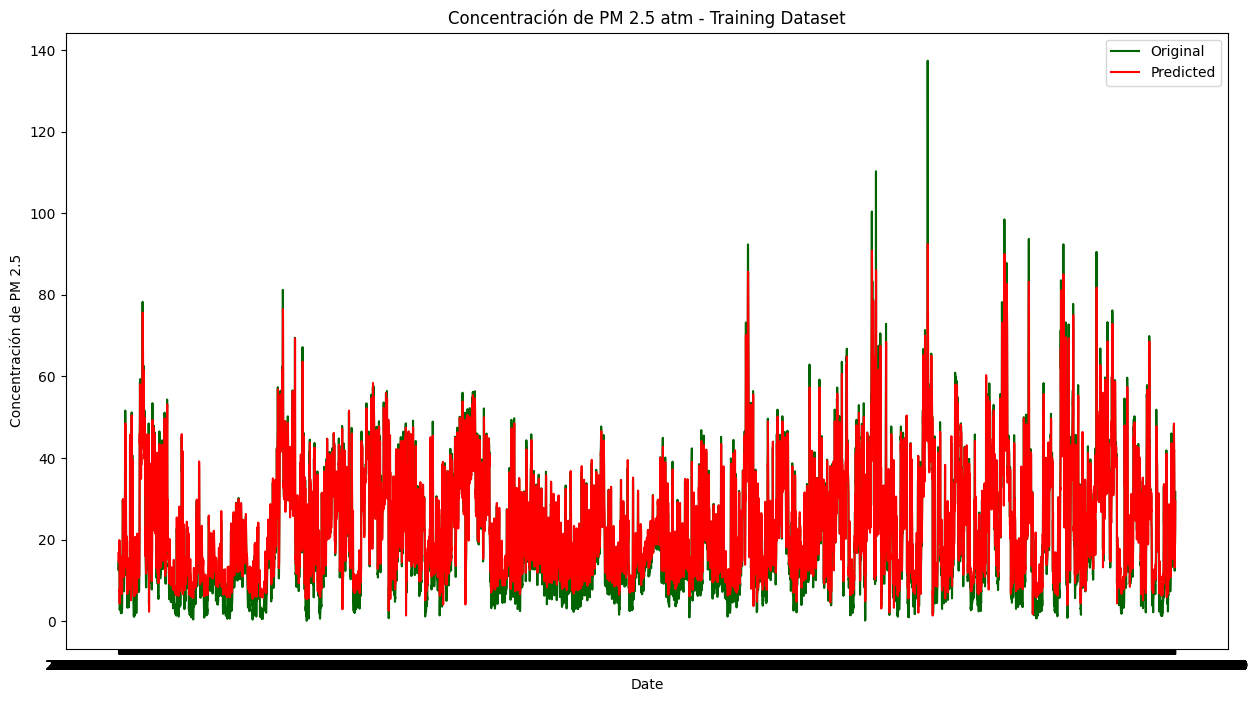

In [12]:
# Gráfica de los datos de etrenamiento junto a las predicciones del modelo
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], y_train_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], train_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Concentración de PM 2.5')
plt.title('Concentración de PM 2.5 atm - Training Dataset')
plt.legend()
plt.show()

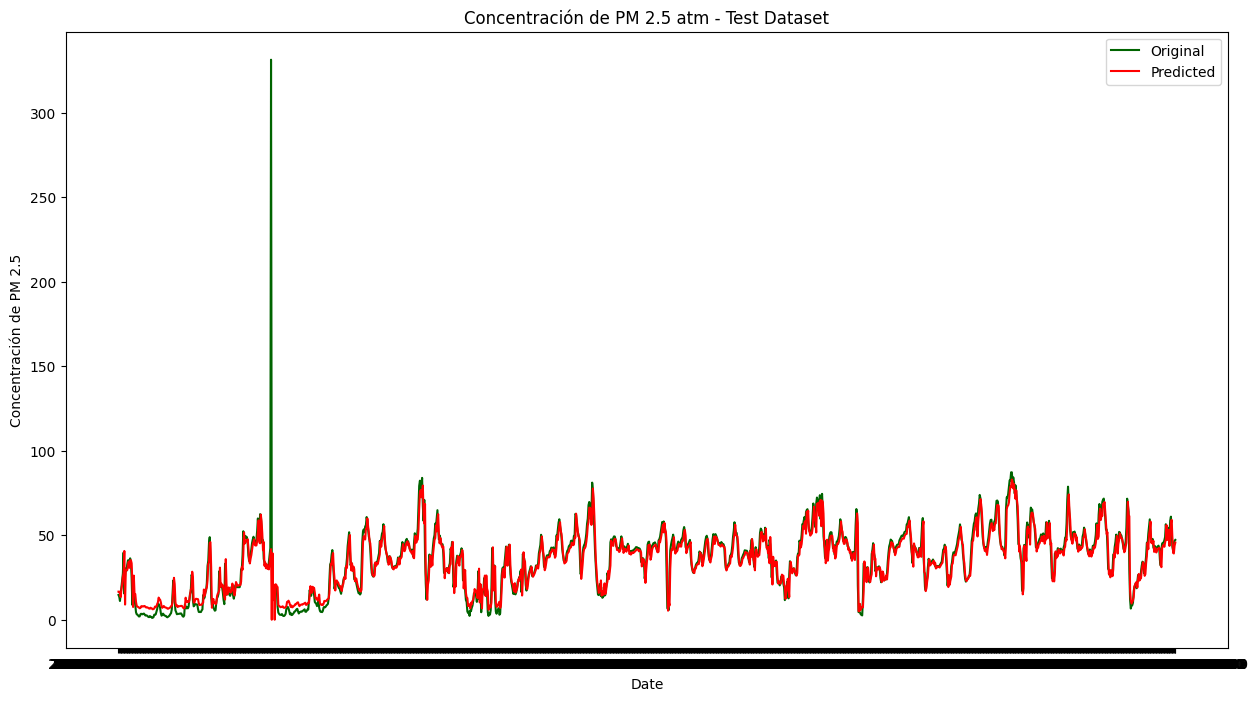

In [13]:
# Gráfica de los datos de testeo junto con las predicciones del modelo
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], y_test_inv, label='Original', color='darkgreen')
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], test_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Concentración de PM 2.5')
plt.title('Concentración de PM 2.5 atm - Test Dataset')
plt.legend()
plt.show()

In [21]:
df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:]

Index(['2024-04-01 6:00:00', '2024-04-01 7:00:00', '2024-04-01 8:00:00',
       '2024-04-01 9:00:00', '2024-04-01 10:00:00', '2024-04-01 11:00:00',
       '2024-04-01 12:00:00', '2024-04-01 13:00:00', '2024-04-01 14:00:00',
       '2024-04-01 15:00:00',
       ...
       '2024-05-31 8:00:00', '2024-05-31 9:00:00', '2024-05-31 10:00:00',
       '2024-05-31 11:00:00', '2024-05-31 12:00:00', '2024-05-31 13:00:00',
       '2024-05-31 14:00:00', '2024-05-31 15:00:00', '2024-05-31 16:00:00',
       '2024-05-31 17:00:00'],
      dtype='object', name='DATE', length=1449)

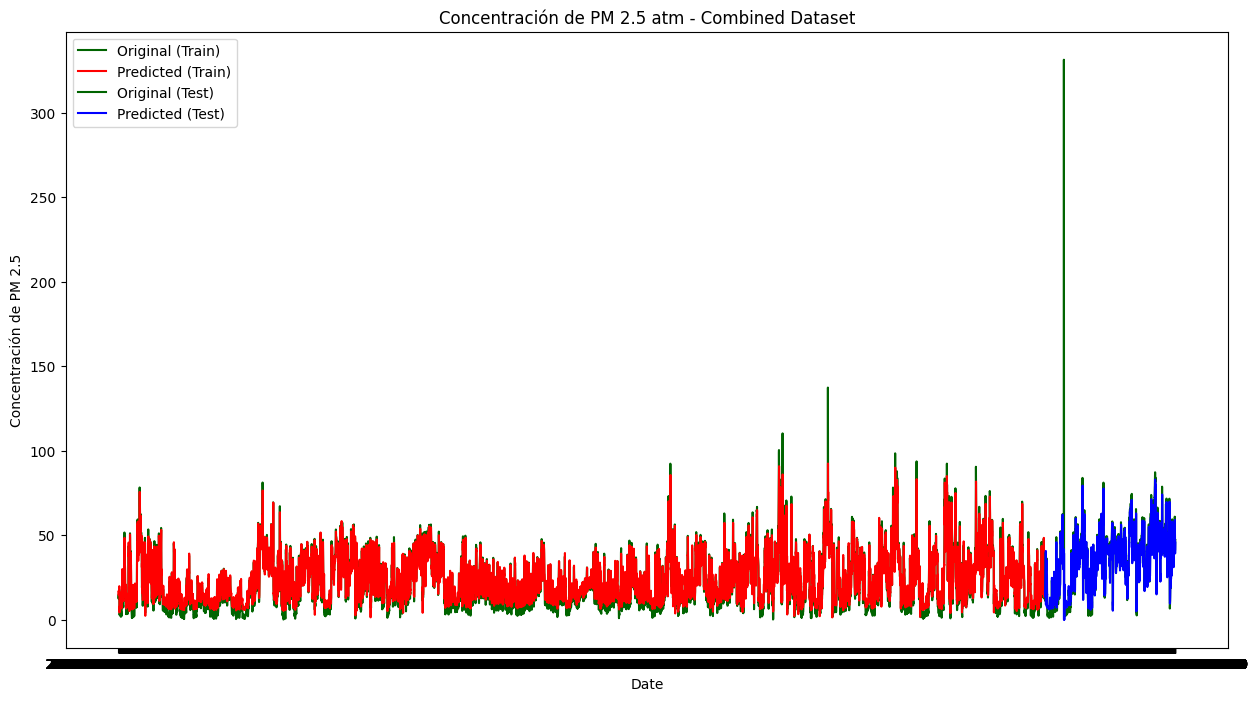

In [14]:
# Gráfica conjunta con los datos de entrenamiento y de testeo para el modelo
plt.figure(figsize=(15, 8))

# Gráfico de los datos de entrenamiento
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], y_train_inv, label='Original (Train)', color='darkgreen')
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(train_pred_inv)], train_pred_inv, label='Predicted (Train)', color='red')

# Gráfico de los datos de testeo
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], y_test_inv, label='Original (Test)', color='darkgreen')
plt.plot(df.index[TIME_STEPS+len(train_pred_inv)+TIME_STEPS:], test_pred_inv, label='Predicted (Test)', color='blue')

plt.xlabel('Date')
plt.ylabel('Concentración de PM 2.5')
plt.title('Concentración de PM 2.5 atm - Combined Dataset')
plt.legend()
plt.show()


In [44]:
type(x_axis[1])

str

#Bibliografía
Sklearn.svm.SVR. (s.f.). Scikit-learn. https://scikit-learn.org/1.4/modules/generated/sklearn.svm.SVR.html
<br>
GeeksforGeeks. (2024, 10 abril). Time Series Forecasting with Support Vector Regression. GeeksforGeeks. https://www.geeksforgeeks.org/time-series-forecasting-with-support-vector-regression/
